The purpose of this document is to create a comparison between two operation modes <br>
   - all counters follow the same rule<br>
   - Common Use Self Bag Drop only opens earlier<br>

# import librairies

In [1]:
import datetime
import math
import os
import random
import time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import OptimizeResult, brute, minimize, minimize_scalar
from tqdm.notebook import tqdm

from src.utils.profiles import generate_dep_Pax_Counters
from src.simfunc.KIX_T1d import (KIX_T1_departure_sim_function,
                                 univariate_cost_function_generator_t1d_N)
from src.simfunc.KIX_T1d_CUSBD import (
    KIX_T1_CUSBD_departure_sim_function,
    univariate_cost_function_generator_t1d_CUSBD_N)
from src.utils.optimizers import custcallback, custmin

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# parameters from "assumption all dept.xlsx" on onedrive
path_onedrive = r"C:\Users\J00638\関西エアポートグループ\Technical HQ department - Masterplan - Masterplan\ADRM model\assumptions all dept\assumptions all dept.xlsx"
df_param_onedrive = pd.read_excel(
    path_onedrive,
    sheet_name="dynamic",
)

# generate df_set_param_T1d_from_drive from one drive excel file (assumptions all dept)
df_param_input = df_param_onedrive.set_index("item", drop=True, inplace=False)

# keep only T1 Int'l dep results
mask_T1d = (df_param_input["terminal"] == "T1") & (df_param_input["Direction"] == "D")
df_param_input_T1 = df_param_input[mask_T1d]

df_param_input_T1 = df_param_input_T1.drop(
    columns=["unit", "terminal", "type", "remarks", "Direction"]
)

# take values from assumption files and put them in a dictionnary
list_item = [
    "target_peak_STD",
    "Pt_checkin_1step_counter",
    "Pt_checkin_2step_counter",
    "N_kiosk",
    "Pt_kiosk",
    "N_security_lanes",
    "Pt_security_lanes",
    "N_emigration_counter",
    "Pt_emigration_counter",
    "N_emigration_self",
    "Pt_emigration_self",
    "modern_pax_ratio",
    "digital_pax_ratio",
    "premium_pax_ratio",
    "start_special_pax_ratio",
    "end_special_pax_ratio",
]

dct_set_param_T1d_from_drive = {
    item: list(df_param_input_T1.loc[item, :]) for item in list_item
}
len_dct_set_param_T1d_from_drive = len(dct_set_param_T1d_from_drive["target_peak_STD"])
dct_set_param_T1d_from_drive["target_peak"] = dct_set_param_T1d_from_drive.pop(
    "target_peak_STD"
)

# define values that are not in assumption files
dct_set_param_T1d_from_drive["freq"] = [
    "1min" for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["win"] = [
    15 for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_loading"] = [
    True for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_xls"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]

# change the start & end special pax, it was a bad idea

dct_set_param_T1d_from_drive["start_special_pax_ratio"] = [
    0.01 for i in range(len_dct_set_param_T1d_from_drive)
]

dct_set_param_T1d_from_drive["end_special_pax_ratio"] = [
    0.99 for i in range(len_dct_set_param_T1d_from_drive)
]

df_set_param_T1d_from_drive = pd.DataFrame.from_dict(dct_set_param_T1d_from_drive)

df_set_param_T1d = df_set_param_T1d_from_drive.copy()
dct_set_param_T1d = dct_set_param_T1d_from_drive.copy()

# create the dictionary of param for the run from the dct_set_param
# we take the values for 2025
dct_run_param = {keys: value[5] for keys, value in dct_set_param_T1d.items()}

# Calculations for report

## helper function for EBS and LBC capac

In [4]:
def calculate_EBS_LBC(
    df_result,
    MUP_open_time=pd.Timedelta(hours=2, minutes=10),
    MUP_close_time=pd.Timedelta(hours=1),
):
    # change the times after midnight to the next day to calculate properly
    end = pd.Timestamp("2020-10-13 02:00:00")
    mask_late_flight = df_result["STD"] < end
    df_result.loc[mask_late_flight, "STD"] += pd.Timedelta(days=1)

    # mask for bags who will use EBS
    # we take start security queue because some come from checkin and some from CUSBD
    # we should also remove no bag pax (TBD)

    mask_EBS = df_result["start_security_queue"] < df_result["STD"] - MUP_open_time
    df_result.loc[mask_EBS, "EBS_in"] = df_result.loc[mask_EBS, "start_security_queue"]
    df_result.loc[mask_EBS, "EBS_out"] = df_result.loc[mask_EBS, "STD"] - MUP_open_time

    plt_in_EBS = (
        df_result.loc[mask_EBS, ["EBS_in", "Pax_N"]]
        .set_index("EBS_in", drop=False)["Pax_N"]
        .resample("15min")
        .agg(["sum"])
        .cumsum()
    )

    plt_out_EBS = (
        df_result.loc[mask_EBS, ["EBS_out", "Pax_N"]]
        .set_index("EBS_out", drop=False)["Pax_N"]
        .resample("15min")
        .agg(["sum"])
        .cumsum()
    )

    EBS_req = (plt_in_EBS - plt_out_EBS).max()

    # mask for bags who will use LBC

    mask_LBC = df_result["start_security_queue"] > df_result["STD"] - MUP_close_time
    df_result.loc[mask_LBC, "LBC_in"] = df_result.loc[mask_LBC, "start_security_queue"]
    df_result.loc[mask_LBC, "LBC_out"] = df_result.loc[mask_LBC, "STD"]

    plt_in_LBC = (
        df_result.loc[mask_LBC, ["LBC_in", "Pax_N"]]
        .set_index("LBC_in", drop=False)["Pax_N"]
        .resample("15min")
        .agg(["sum"])
        .cumsum()
    )

    plt_out_LBC = (
        df_result.loc[mask_LBC, ["LBC_out", "Pax_N"]]
        .set_index("LBC_out", drop=False)["Pax_N"]
        .resample("15min")
        .agg(["sum"])
        .cumsum()
    )

    LBC_req = (plt_in_LBC - plt_out_LBC).max()

    return EBS_req, LBC_req

In [5]:
def calculate_avg_dwell_time(df_result, offset=pd.Timedelta(minutes=15)):
    """
    we could use: df_result[["end_emigration_self_process", "end_emigration_counter_process"]]
    but as we do not consider immigration here (check-in study)
    let's consider Pax take about 15 minutes to clear immigration
    """
    # change the times after midnight to the next day to calculate properly
    end = pd.Timestamp("2020-10-13 02:00:00")
    mask_late_flight = df_result["STD"] < end
    df_result.loc[mask_late_flight, "STD"] += pd.Timedelta(days=1)

    df_dwell = df_result["STD"] - (df_result["end_security_process"] + offset)

    q_high = df_dwell.quantile(q=0.90)
    q_low = df_dwell.quantile(q=0.10)

    mask_q = (q_low < df_dwell) & (df_dwell < q_high)

    mean = df_dwell[mask_q].mean() / pd.Timedelta(minutes=1)
    top90 = df_dwell.quantile(q=0.9) / pd.Timedelta(minutes=1)

    return df_dwell, mean, top90

## all counters have new rule

### import dct_param_onderive

In [6]:
# parameters from "assumption all dept.xlsx" on onedrive
path_onedrive = r"C:\Users\J00638\関西エアポートグループ\Technical HQ department - Masterplan - Masterplan\ADRM model\assumptions all dept\assumptions all dept.xlsx"
df_param_onedrive = pd.read_excel(
    path_onedrive,
    sheet_name="dynamic",
)

# generate df_set_param_T1d_from_drive from one drive excel file (assumptions all dept)
df_param_input = df_param_onedrive.set_index("item", drop=True, inplace=False)

# keep only T1 Int'l dep results
mask_T1d = (df_param_input["terminal"] == "T1") & (df_param_input["Direction"] == "D")
df_param_input_T1 = df_param_input[mask_T1d]

df_param_input_T1 = df_param_input_T1.drop(
    columns=["unit", "terminal", "type", "remarks", "Direction"]
)

# take values from assumption files and put them in a dictionnary
list_item = [
    "target_peak_STD",
    "Pt_checkin_1step_counter",
    "Pt_checkin_2step_counter",
    "N_kiosk",
    "Pt_kiosk",
    "N_security_lanes",
    "Pt_security_lanes",
    "N_emigration_counter",
    "Pt_emigration_counter",
    "N_emigration_self",
    "Pt_emigration_self",
    "modern_pax_ratio",
    "digital_pax_ratio",
    "premium_pax_ratio",
    "start_special_pax_ratio",
    "end_special_pax_ratio",
]

dct_set_param_T1d_from_drive = {
    item: list(df_param_input_T1.loc[item, :]) for item in list_item
}
len_dct_set_param_T1d_from_drive = len(dct_set_param_T1d_from_drive["target_peak_STD"])
dct_set_param_T1d_from_drive["target_peak"] = dct_set_param_T1d_from_drive.pop(
    "target_peak_STD"
)

# define values that are not in assumption files
dct_set_param_T1d_from_drive["freq"] = [
    "1min" for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["win"] = [
    15 for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_loading"] = [
    True for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_xls"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]

# change the start & end special pax, it was a bad idea

dct_set_param_T1d_from_drive["start_special_pax_ratio"] = [
    0.01 for i in range(len_dct_set_param_T1d_from_drive)
]

dct_set_param_T1d_from_drive["end_special_pax_ratio"] = [
    0.99 for i in range(len_dct_set_param_T1d_from_drive)
]

df_set_param_T1d_from_drive = pd.DataFrame.from_dict(dct_set_param_T1d_from_drive)

df_set_param_T1d = df_set_param_T1d_from_drive.copy()
dct_set_param_T1d = dct_set_param_T1d_from_drive.copy()

# create the dictionary of param for the run from the dct_set_param
# we take the values for 2025
dct_run_param = {keys: value[5] for keys, value in dct_set_param_T1d.items()}

### calculate

In [7]:
# define the optimization parameters
dct_target_wait_time = {
    "kiosk": 1.5,  # IATA optimum is 1-2 minutes
    "CUSBD": 3,  # IATA optimum is 1-5 minutes
}

opening_hour_list = [2.5, 3, 3.5, 4]  # we also consider current case
two_step_ratio_list = [0.2, 0.5, 0.8]

system_list = ["N_kiosk"]
all_system_list = [
    "N_kiosk",
    "N_security_lanes",
    "N_emigration_counter",
    "N_emigration_self",
]
other_result_list = ["N_Counters", "waiting_time_counters", "EBS", "LBC"]

# initialize a path
path_dump = "C:\\Users\\J00638\\KAP python\\Airport sim\\set_runs_departureCUSBD\\set_test\\run_checkin_rule_newloliloul"

# initialize df_results
# column_opening_hour = [a for a in opening_hour_list for b in two_step_ratio_list]
# column_two_step_ratio = [a for b in opening_hour_list for a in two_step_ratio_list]

# index_result_opti = range(len(column_opening_hour))
# columns_list = ["opening_hour", "two_step_ratio"] + system_list + other_result_list
# df_result_opti = pd.DataFrame(columns=columns_list, index=index_result_opti)

# df_result_opti["opening_hour"] = column_opening_hour
# df_result_opti["two_step_ratio"] = column_two_step_ratio

# create dct_param_opti
dct_param_opti = dct_run_param.copy()
dct_param_opti.pop("target_peak", None)

# define dct of edited check-in rule
dct_kwargs_rules = {
    2.5: {
        "start_time": 2.5,
        "onecounter_time": 0.75,
        "base_n_counter": 4,
        "seats_per_add_counter": 60,
    },
    3: {
        "start_time": 3,
        "onecounter_time": 0.75,
        "base_n_counter": 3,
        "seats_per_add_counter": 75,
    },
    3.5: {
        "start_time": 3.5,
        "onecounter_time": 0.75,
        "base_n_counter": 3,
        "seats_per_add_counter": 90,
    },
    4: {
        "start_time": 4,
        "onecounter_time": 0.75,
        "base_n_counter": 3,
        "seats_per_add_counter": 105,
    },
}

In [ ]:
for opening_hour in opening_hour_list:
    # generate df_Counters
    
    # retrieve relevant kwargs_rule
    kwargs_rule = dct_kwargs_rules[opening_hour]

    _, df_Counters = generate_dep_Pax_Counters(
        target_peak=3580,
        terminal="T1",
        custom_counter_rule=True,
        **kwargs_rule,
    )

    # store result
    mask = df_result_opti["opening_hour"] == opening_hour
    df_result_opti.loc[mask, "N_Counters"] = df_Counters["total"].max()

    # as we generated base case df_Pax and df_Counters already
    dct_param_opti["df_Pax"] = df_Pax
    dct_param_opti["df_Counters"] = df_Counters

    for two_step_ratio in two_step_ratio_list:
        dct_param_opti["modern_pax_ratio"] = (
            two_step_ratio - 0.05
        )  # digital pax do not change

        for variable in system_list:
            # edit dct_param_opti
            dct_param_opti["path"] = path_dump

            # optimize current system
            # refresh the kwargs (with eventually results from last optimization)
            kwargs = {
                "dct_param_T1d": dct_param_opti,
                "variable_string": variable,  # eg. N_Z, N_kiosk, N_CUSBD
                "target_wait_time": dct_target_wait_time[
                    variable.split("_")[1]
                ],  # target waiting time in minutes for each system, same for all system for now
                "call_n_iter": None,
                "totalpbar": None,
            }

            # options for custom optimizer, first guess is taken from dct_year base value
            options = {
                "guess": int(49),
                "maxfev": 30,
                "bigstep": 10,
                "smallstep": 1,
                "callback": custcallback,
                "tol": 1,
            }

            # run the optimization for that variable
            print(
                "optimization for {} with:\n rule: opening {}hr before\n two_step_ratio = {}".format(
                    variable, opening_hour, two_step_ratio
                )
            )
            f = univariate_cost_function_generator_t1d_N(**kwargs)
            res = custmin(f, **options)
            print(res)

            # store in this loop's dct for next system
            dct_param_opti[variable] = res["x"]

            # store result
            mask = (df_result_opti["opening_hour"] == opening_hour) & (
                df_result_opti["two_step_ratio"] == two_step_ratio
            )
            df_result_opti.loc[mask, variable] = res["x"]

        # run the optimized simulation once to get the waiting time, EBS and LBC numbers
        (
            df_result,
            list_KPI_run,
            dct_hist_wait_time,
            dct_hist_queue_length,
        ) = KIX_T1_departure_sim_function(**dct_param_opti)

        # store result for waiting time
        mask = (df_result_opti["opening_hour"] == opening_hour) & (
            df_result_opti["two_step_ratio"] == two_step_ratio
        )
        df_result_opti.loc[mask, "waiting_time_counters"] = dct_hist_wait_time[
            "checkin_counter"
        ].quantile(q=0.9)

        # store result for EBS and LBC
        EBS_req, LBC_req = calculate_EBS_LBC(df_result)
        df_result_opti.loc[mask, "EBS"] = int(EBS_req)
        df_result_opti.loc[mask, "LBC"] = int(LBC_req)
        
        # store result for dwell time        
        df_dwell, mean, top90 = calculate_avg_dwell_time(df_result)        
        df_result_opti.loc[mask, "dwell_time"] = mean
        df_result_opti.loc[mask, "df_dwell_time"] = df_dwell

In [ ]:
df_result_opti

### re-calculate EBS, LBS and dwell time

In [ ]:
# re run the EBS, LBC and dwell time
opening_hour_list = [2.5, 3, 3.5, 4]  # we also consider current case
two_step_ratio_list = [0.2, 0.5, 0.8]

for opening_hour in opening_hour_list:
    # generate df_Counters

    # retrieve relevant kwargs_rule
    kwargs_rule = dct_kwargs_rules[opening_hour]

    df_Pax, df_Counters = generate_dep_Pax_Counters(
        target_peak=3580,
        terminal="T1",
        custom_counter_rule=True,
        **kwargs_rule,
    )

    # as we generated base case df_Pax and df_Counters already
    dct_param_opti["df_Pax"] = df_Pax
    dct_param_opti["df_Counters"] = df_Counters

    for two_step_ratio in two_step_ratio_list:
        dct_param_opti["modern_pax_ratio"] = (
            two_step_ratio - 0.05
        )  # digital pax do not change

        mask = (df_result_opti["opening_hour"] == opening_hour) & (
            df_result_opti["two_step_ratio"] == two_step_ratio
        )
        dct_param_opti["N_kiosk"] = df_result_opti.loc[mask, "N_kiosk"].values[0]

        (
            df_result,
            list_KPI_run,
            dct_hist_wait_time,
            dct_hist_queue_length,
        ) = KIX_T1_departure_sim_function(**dct_param_opti)

        # store result for EBS and LBC
        EBS_req, LBC_req = calculate_EBS_LBC(df_result)
        df_result_opti.loc[mask, "EBS"] = int(EBS_req)
        df_result_opti.loc[mask, "LBC"] = int(LBC_req)

        # store result for dwell time
        df_dwell, mean, top90 = calculate_avg_dwell_time(df_result)
        df_result_opti.loc[mask, "dwell_time"] = mean
        df_result_opti.loc[mask, "df_dwell_time"] = df_dwell

In [ ]:
df_result_opti

In [ ]:
df_result_opti_all_counters = df_result_opti[
    [
        "opening_hour",
        "two_step_ratio",
        "N_kiosk",
        "N_Counters",
        "waiting_time_counters",
        "EBS",
        "LBC",
        "dwell_time",
    ]
].copy()

In [ ]:
df_result_opti_all_counters

## CUSBD

### import dct_param_onderive

In [8]:
# parameters from "assumption all dept.xlsx" on onedrive
path_onedrive = r"C:\Users\J00638\関西エアポートグループ\Technical HQ department - Masterplan - Masterplan\ADRM model\assumptions all dept\assumptions all dept.xlsx"
df_param_onedrive = pd.read_excel(
    path_onedrive,
    sheet_name="dynamic",
)

# generate df_set_param_T1d_from_drive from one drive excel file (assumptions all dept)
df_param_input = df_param_onedrive.set_index("item", drop=True, inplace=False)

# keep only T1 Int'l dep results
mask_T1d = (df_param_input["terminal"] == "T1") & (df_param_input["Direction"] == "D")
df_param_input_T1 = df_param_input[mask_T1d]

df_param_input_T1 = df_param_input_T1.drop(
    columns=["unit", "terminal", "type", "remarks", "Direction"]
)

# take values from assumption files and put them in a dictionnary
list_item = [
    "target_peak_STD",
    "Pt_checkin_1step_counter",
    "Pt_checkin_2step_counter",
    "N_kiosk",
    "Pt_kiosk",
    "N_security_lanes",
    "Pt_security_lanes",
    "N_emigration_counter",
    "Pt_emigration_counter",
    "N_emigration_self",
    "Pt_emigration_self",
    "modern_pax_ratio",
    "digital_pax_ratio",
    "premium_pax_ratio",
    "start_special_pax_ratio",
    "end_special_pax_ratio",
]

dct_set_param_T1d_from_drive = {
    item: list(df_param_input_T1.loc[item, :]) for item in list_item
}
len_dct_set_param_T1d_from_drive = len(dct_set_param_T1d_from_drive["target_peak_STD"])
dct_set_param_T1d_from_drive["target_peak"] = dct_set_param_T1d_from_drive.pop(
    "target_peak_STD"
)

# define values that are not in assumption files
dct_set_param_T1d_from_drive["freq"] = [
    "1min" for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["win"] = [
    15 for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_loading"] = [
    True for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_xls"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]

# change the start & end special pax, it was a bad idea

dct_set_param_T1d_from_drive["start_special_pax_ratio"] = [
    0.01 for i in range(len_dct_set_param_T1d_from_drive)
]

dct_set_param_T1d_from_drive["end_special_pax_ratio"] = [
    0.99 for i in range(len_dct_set_param_T1d_from_drive)
]

df_set_param_T1d_from_drive = pd.DataFrame.from_dict(dct_set_param_T1d_from_drive)

df_set_param_T1d = df_set_param_T1d_from_drive.copy()
dct_set_param_T1d = dct_set_param_T1d_from_drive.copy()

# create the dictionary of param for the run from the dct_set_param
# we take the values for 2025
dct_run_param = {keys: value[5] for keys, value in dct_set_param_T1d.items()}

### calculate

In [ ]:
# define the optimization parameters
dct_target_wait_time = {
    "kiosk": 1.5,  # IATA optimum is 1-2 minutes
    "CUSBD": 3,  # IATA optimum is 1-5 minutes
}

opening_hour_list = [3, 3.5, 4, 12]  # we also consider current case and 12 hours before
two_step_ratio_list = [0.8]#[0.2, 0.5, 0.8]

system_list = ["N_kiosk","N_CUSBD"]
all_system_list = [
    "N_kiosk",
    "N_security_lanes",
    "N_emigration_counter",
    "N_emigration_self",
]
other_result_list = ["N_Counters", "waiting_time_counters", "EBS", "LBC"]

# initialize a path
path_dump = "C:\\Users\\J00638\\KAP python\\Airport sim\\set_runs_departureCUSBD\\set_test\\run_checkin_rule_newloliloul"

# initialize df_results
column_opening_hour = [a for a in opening_hour_list for b in two_step_ratio_list]
column_two_step_ratio = [a for b in opening_hour_list for a in two_step_ratio_list]

index_result_opti = range(len(column_opening_hour))
columns_list = ["opening_hour", "two_step_ratio"] + system_list + other_result_list
df_result_opti_CUSBD = pd.DataFrame(columns=columns_list, index=index_result_opti)

df_result_opti_CUSBD["opening_hour"] = column_opening_hour
df_result_opti_CUSBD["two_step_ratio"] = column_two_step_ratio

# create dct_param_opti_CUSBD
dct_param_opti_CUSBD = dct_run_param.copy()
dct_param_opti_CUSBD.pop("target_peak", None)
dct_param_opti_CUSBD['N_CUSBD'] = 24
dct_param_opti_CUSBD['CUSBD_opening_duration'] = 3*60


In [ ]:
for opening_hour in opening_hour_list:

    dct_param_opti_CUSBD["CUSBD_opening_duration"] = opening_hour * 60

    for two_step_ratio in two_step_ratio_list:
        dct_param_opti_CUSBD["modern_pax_ratio"] = (
            two_step_ratio - 0.05
        )  # digital pax do not change

        # retrieve relevant kwargs_rule
        kwargs_rule = {
            "start_time": 2.5,
            "onecounter_time": 0.75,
            "base_n_counter": math.ceil(3 * (1 - two_step_ratio)),
            "seats_per_add_counter": math.ceil(60 / (1 - two_step_ratio)),
        }

        df_Pax, df_Counters = generate_dep_Pax_Counters(
            target_peak=3580,
            terminal="T1",
            custom_counter_rule=True,
            **kwargs_rule,
        )

        # store result
        mask = (df_result_opti_CUSBD["opening_hour"] == opening_hour) & (
            df_result_opti_CUSBD["two_step_ratio"] == two_step_ratio
        )
        df_result_opti_CUSBD.loc[mask, "N_Counters"] = df_Counters["total"].max()

        # as we generated base case df_Pax and df_Counters already
        dct_param_opti_CUSBD["df_Pax"] = df_Pax
        dct_param_opti_CUSBD["df_Counters"] = df_Counters

        for variable in system_list:
            # edit dct_param_opti_CUSBD
            dct_param_opti_CUSBD["path"] = path_dump

            # optimize current system
            # refresh the kwargs (with eventually results from last optimization)
            kwargs = {
                "dct_param_T1d": dct_param_opti_CUSBD,
                "variable_string": variable,  # eg. N_Z, N_kiosk, N_CUSBD
                "target_wait_time": dct_target_wait_time[
                    variable.split("_")[1]
                ],  # target waiting time in minutes for each system, same for all system for now
                "call_n_iter": None,
                "totalpbar": None,
            }

            # options for custom optimizer, first guess is taken from dct_year base value
            options = {
                "guess": int(49),
                "maxfev": 30,
                "bigstep": 10,
                "smallstep": 1,
                "callback": custcallback,
                "tol": 1,
            }

            # run the optimization for that variable
            print(
                "optimization for {} with:\n rule: opening {}hr before\n two_step_ratio = {}".format(
                    variable, opening_hour, two_step_ratio
                )
            )
            f = univariate_cost_function_generator_t1d_CUSBD_N(**kwargs)
            res = custmin(f, **options)
            print(res)

            # store in this loop's dct for next system
            dct_param_opti_CUSBD[variable] = res["x"]

            # store result
            mask = (df_result_opti_CUSBD["opening_hour"] == opening_hour) & (
                df_result_opti_CUSBD["two_step_ratio"] == two_step_ratio
            )
            df_result_opti_CUSBD.loc[mask, variable] = res["x"]

        # run the optimized simulation once to get the waiting time, EBS and LBC numbers
        (
            df_result,
            list_KPI_run,
            dct_hist_wait_time,
            dct_hist_queue_length,
        ) = KIX_T1_CUSBD_departure_sim_function(**dct_param_opti_CUSBD)

        # store result for waiting time
        mask = (df_result_opti_CUSBD["opening_hour"] == opening_hour) & (
            df_result_opti_CUSBD["two_step_ratio"] == two_step_ratio
        )
        df_result_opti_CUSBD.loc[mask, "waiting_time_counters"] = dct_hist_wait_time[
            "checkin_counter"
        ].quantile(q=0.9)

        # store result for EBS and LBC
        EBS_req, LBC_req = calculate_EBS_LBC(df_result)
        df_result_opti_CUSBD.loc[mask, "EBS"] = int(EBS_req)
        df_result_opti_CUSBD.loc[mask, "LBC"] = int(LBC_req)

        # store result for dwell time
        df_dwell, mean, top90 = calculate_avg_dwell_time(df_result)
        df_result_opti_CUSBD.loc[mask, "dwell_time"] = mean
        df_result_opti_CUSBD.loc[mask, "df_dwell_time"] = df_dwell

In [ ]:
df_result_opti_CUSBD_run3 = df_result_opti_CUSBD.copy()
df_result_opti_CUSBD_run3

In [ ]:
df_result_opti_CUSBD_run4

In [ ]:
path_test = r"C:\Users\J00638\Desktop\opti_results.xlsx"

data_test = pd.read_excel(path_test, sheet_name="Sheet2")
data_test

### re-calculate EBS, LBC and dwell time

In [ ]:
df_result_opti_CUSB = data_test

In [ ]:
for opening_hour in opening_hour_list:

    dct_param_opti_CUSBD["CUSBD_opening_duration"] = opening_hour * 60

    for two_step_ratio in two_step_ratio_list:
        dct_param_opti_CUSBD["modern_pax_ratio"] = (
            two_step_ratio - 0.05
        )  # digital pax do not change

        # input N_kiosk and N_CUSBD from df_result
        mask = (df_result_opti_CUSBD["opening_hour"] == opening_hour) & (
            df_result_opti_CUSBD["two_step_ratio"] == two_step_ratio
        )
        dct_param_opti_CUSBD["N_kiosk"] = df_result_opti_CUSBD.loc[
            mask, "N_kiosk"
        ].values[0]

        dct_param_opti_CUSBD["N_CUSBD"] = df_result_opti_CUSBD.loc[
            mask, "N_CUSBD"
        ].values[0]

        # retrieve relevant kwargs_rule
        kwargs_rule = {
            "start_time": 2.5,
            "onecounter_time": 0.75,
            "base_n_counter": math.ceil(3 * (1 - two_step_ratio)),
            "seats_per_add_counter": math.ceil(60 / (1 - two_step_ratio)),
        }

        df_Pax, df_Counters = generate_dep_Pax_Counters(
            target_peak=3580,
            terminal="T1",
            custom_counter_rule=True,
            **kwargs_rule,
        )

        # store result
        mask = (df_result_opti_CUSBD["opening_hour"] == opening_hour) & (
            df_result_opti_CUSBD["two_step_ratio"] == two_step_ratio
        )

        # as we generated base case df_Pax and df_Counters already
        dct_param_opti_CUSBD["df_Pax"] = df_Pax
        dct_param_opti_CUSBD["df_Counters"] = df_Counters

        # run the optimized simulation once to get the waiting time, EBS and LBC numbers
        (
            df_result,
            list_KPI_run,
            dct_hist_wait_time,
            dct_hist_queue_length,
        ) = KIX_T1_CUSBD_departure_sim_function(**dct_param_opti_CUSBD)

        # store result for waiting time
        mask = (df_result_opti_CUSBD["opening_hour"] == opening_hour) & (
            df_result_opti_CUSBD["two_step_ratio"] == two_step_ratio
        )
        df_result_opti_CUSBD.loc[mask, "waiting_time_counters"] = dct_hist_wait_time[
            "checkin_counter"
        ].quantile(q=0.9)

        # store result for EBS and LBC
        EBS_req, LBC_req = calculate_EBS_LBC(df_result)
        df_result_opti_CUSBD.loc[mask, "EBS"] = int(EBS_req)
        df_result_opti_CUSBD.loc[mask, "LBC"] = int(LBC_req)

        # store result for dwell time
        df_dwell, mean, top90 = calculate_avg_dwell_time(df_result)
        df_result_opti_CUSBD.loc[mask, "dwell_time"] = mean
        df_result_opti_CUSBD.loc[mask, "df_dwell_time"] = df_dwell

In [ ]:
df_result_opti_CUSBD.groupby(["opening_hour", "two_step_ratio"]).sum()

In [ ]:
mask = df_result_opti_CUSBD["opening_hour"] != 12
df_CUSBD = (
    df_result_opti_CUSBD[mask]
    .fillna("")
    .groupby(["opening_hour", "two_step_ratio"])
    .agg("sum")
)

In [ ]:
df_all_counters = (
    df_result_opti[
        [
            "opening_hour",
            "two_step_ratio",
            "N_kiosk",
            "CUSBD",
            "N_Counters",
            "waiting_time_counters",
            "EBS",
            "LBC",
            "dwell_time",
            "df_dwell_time",
        ]
    ]
    .fillna("")
    .groupby(["opening_hour", "two_step_ratio"])
    .agg("sum")
)

In [ ]:
writer = pd.ExcelWriter(
    r"C:\Users\J00638\KAP python\Airport sim\opti_results.xlsx",
)

In [ ]:
df_CUSBD.to_excel(writer, sheet_name="CUSBD")
df_all_counters.to_excel(writer, sheet_name="all_counters")
writer.save()

In [ ]:
pd.DataFrame(df_all_counters)

In [ ]:
df_result_opti_output.to_excel(writer, sheet_name="CUSBD")

In [ ]:
df_result_opti_CUSB

# Test

In [9]:
opening_hour_list = [2.5]
two_step_ratio_list = [0.2]


for opening_hour in opening_hour_list:
    # generate df_Counters
    
    # retrieve relevant kwargs_rule
    kwargs_rule = dct_kwargs_rules[opening_hour]

    df_Pax, df_Counters = generate_dep_Pax_Counters(
        target_peak=500,
        terminal="T1",
        custom_counter_rule=True,
        **kwargs_rule,
    )

    # as we generated base case df_Pax and df_Counters already
    dct_param_opti["df_Pax"] = df_Pax
    dct_param_opti["df_Counters"] = df_Counters

    for two_step_ratio in two_step_ratio_list:
        dct_param_opti["modern_pax_ratio"] = (
            two_step_ratio - 0.05
        )  # digital pax do not change

        for variable in system_list:
            # edit dct_param_opti
            dct_param_opti["path"] = path_dump

            # optimize current system
            # refresh the kwargs (with eventually results from last optimization)
            kwargs = {
                "dct_param_T1d": dct_param_opti,
                "variable_string": variable,  # eg. N_Z, N_kiosk, N_CUSBD
                "target_wait_time": dct_target_wait_time[
                    variable.split("_")[1]
                ],  # target waiting time in minutes for each system, same for all system for now
                "call_n_iter": None,
                "totalpbar": None,
            }

            # options for custom optimizer, first guess is taken from dct_year base value
            options = {
                "guess": int(49),
                "maxfev": 30,
                "bigstep": 10,
                "smallstep": 1,
                "callback": custcallback,
                "tol": 1,
            }

            # run the optimization for that variable
            print(
                "optimization for {} with:\n rule: opening {}hr before\n two_step_ratio = {}".format(
                    variable, opening_hour, two_step_ratio
                )
            )
            f = univariate_cost_function_generator_t1d_N(**kwargs)
            res = custmin(f, **options)
            print(res)

            # store in this loop's dct for next system
            dct_param_opti[variable] = res["x"]

        # run the optimized simulation once to get the waiting time, EBS and LBC numbers
        (
            df_result,
            list_KPI_run,
            dct_hist_wait_time,
            dct_hist_queue_length,
        ) = KIX_T1_CUSBD_departure_sim_function(**dct_param_opti)

        dct_hist_wait_time[
            "checkin_counter"
        ].quantile(q=0.9)

        # store result for EBS and LBC
        EBS_req, LBC_req = calculate_EBS_LBC(df_result)
   
        df_dwell, mean, top90 = calculate_avg_dwell_time(df_result)        


Simulation running...:   0%|          | 0/1440 [00:00<?, ?it/s]optimization for N_kiosk with:
 rule: opening 2.5hr before
 two_step_ratio = 0.2
Simulation running...: 100%|██████████| 1440/1440 [00:17<00:00, 81.32it/s] 
iteration #10:   x=4   error=2.2504  function evaluated 12 times step taken: -1
Simulation running...: 100%|██████████| 1440/1440 [00:18<00:00, 79.38it/s] 
     fun: 0.7224999999999999
    nfev: 14
     nit: 12
 success: True
       x: 2


NameError: name 'KIX_T1_departure_sim_function_CUSBD' is not defined

In [ ]:
import time
for i in range(99999999):
    time.sleep(i)

# focus on one line

## All counters

Simulation running...: 100%|███████████████████████████████████████████████████████| 1440/1440 [05:49<00:00,  4.13it/s]


                                                path  \
0  C:\Users\J00638\KAP python\Airport sim\set_run...   

   Pt_checkin_1step_counter  Pt_checkin_2step_counter  N_kiosk  Pt_kiosk  \
0                  1.603333                      1.27     92.0       1.5   

   N_security_lanes  Pt_security_lanes  N_emigration_counter  \
0              22.0           0.233333                  26.0   

   Pt_emigration_counter  N_emigration_self  ...  premium_pax_ratio  \
0               0.383333               31.0  ...               0.05   

   start_special_pax_ratio  end_special_pax_ratio  freq  win  show_loading  \
0                     0.01                   0.99  1min   15          True   

  show_graph  save_graph  save_xls  call_n_iter  
0       True       False     False         None  

[1 rows x 23 columns]


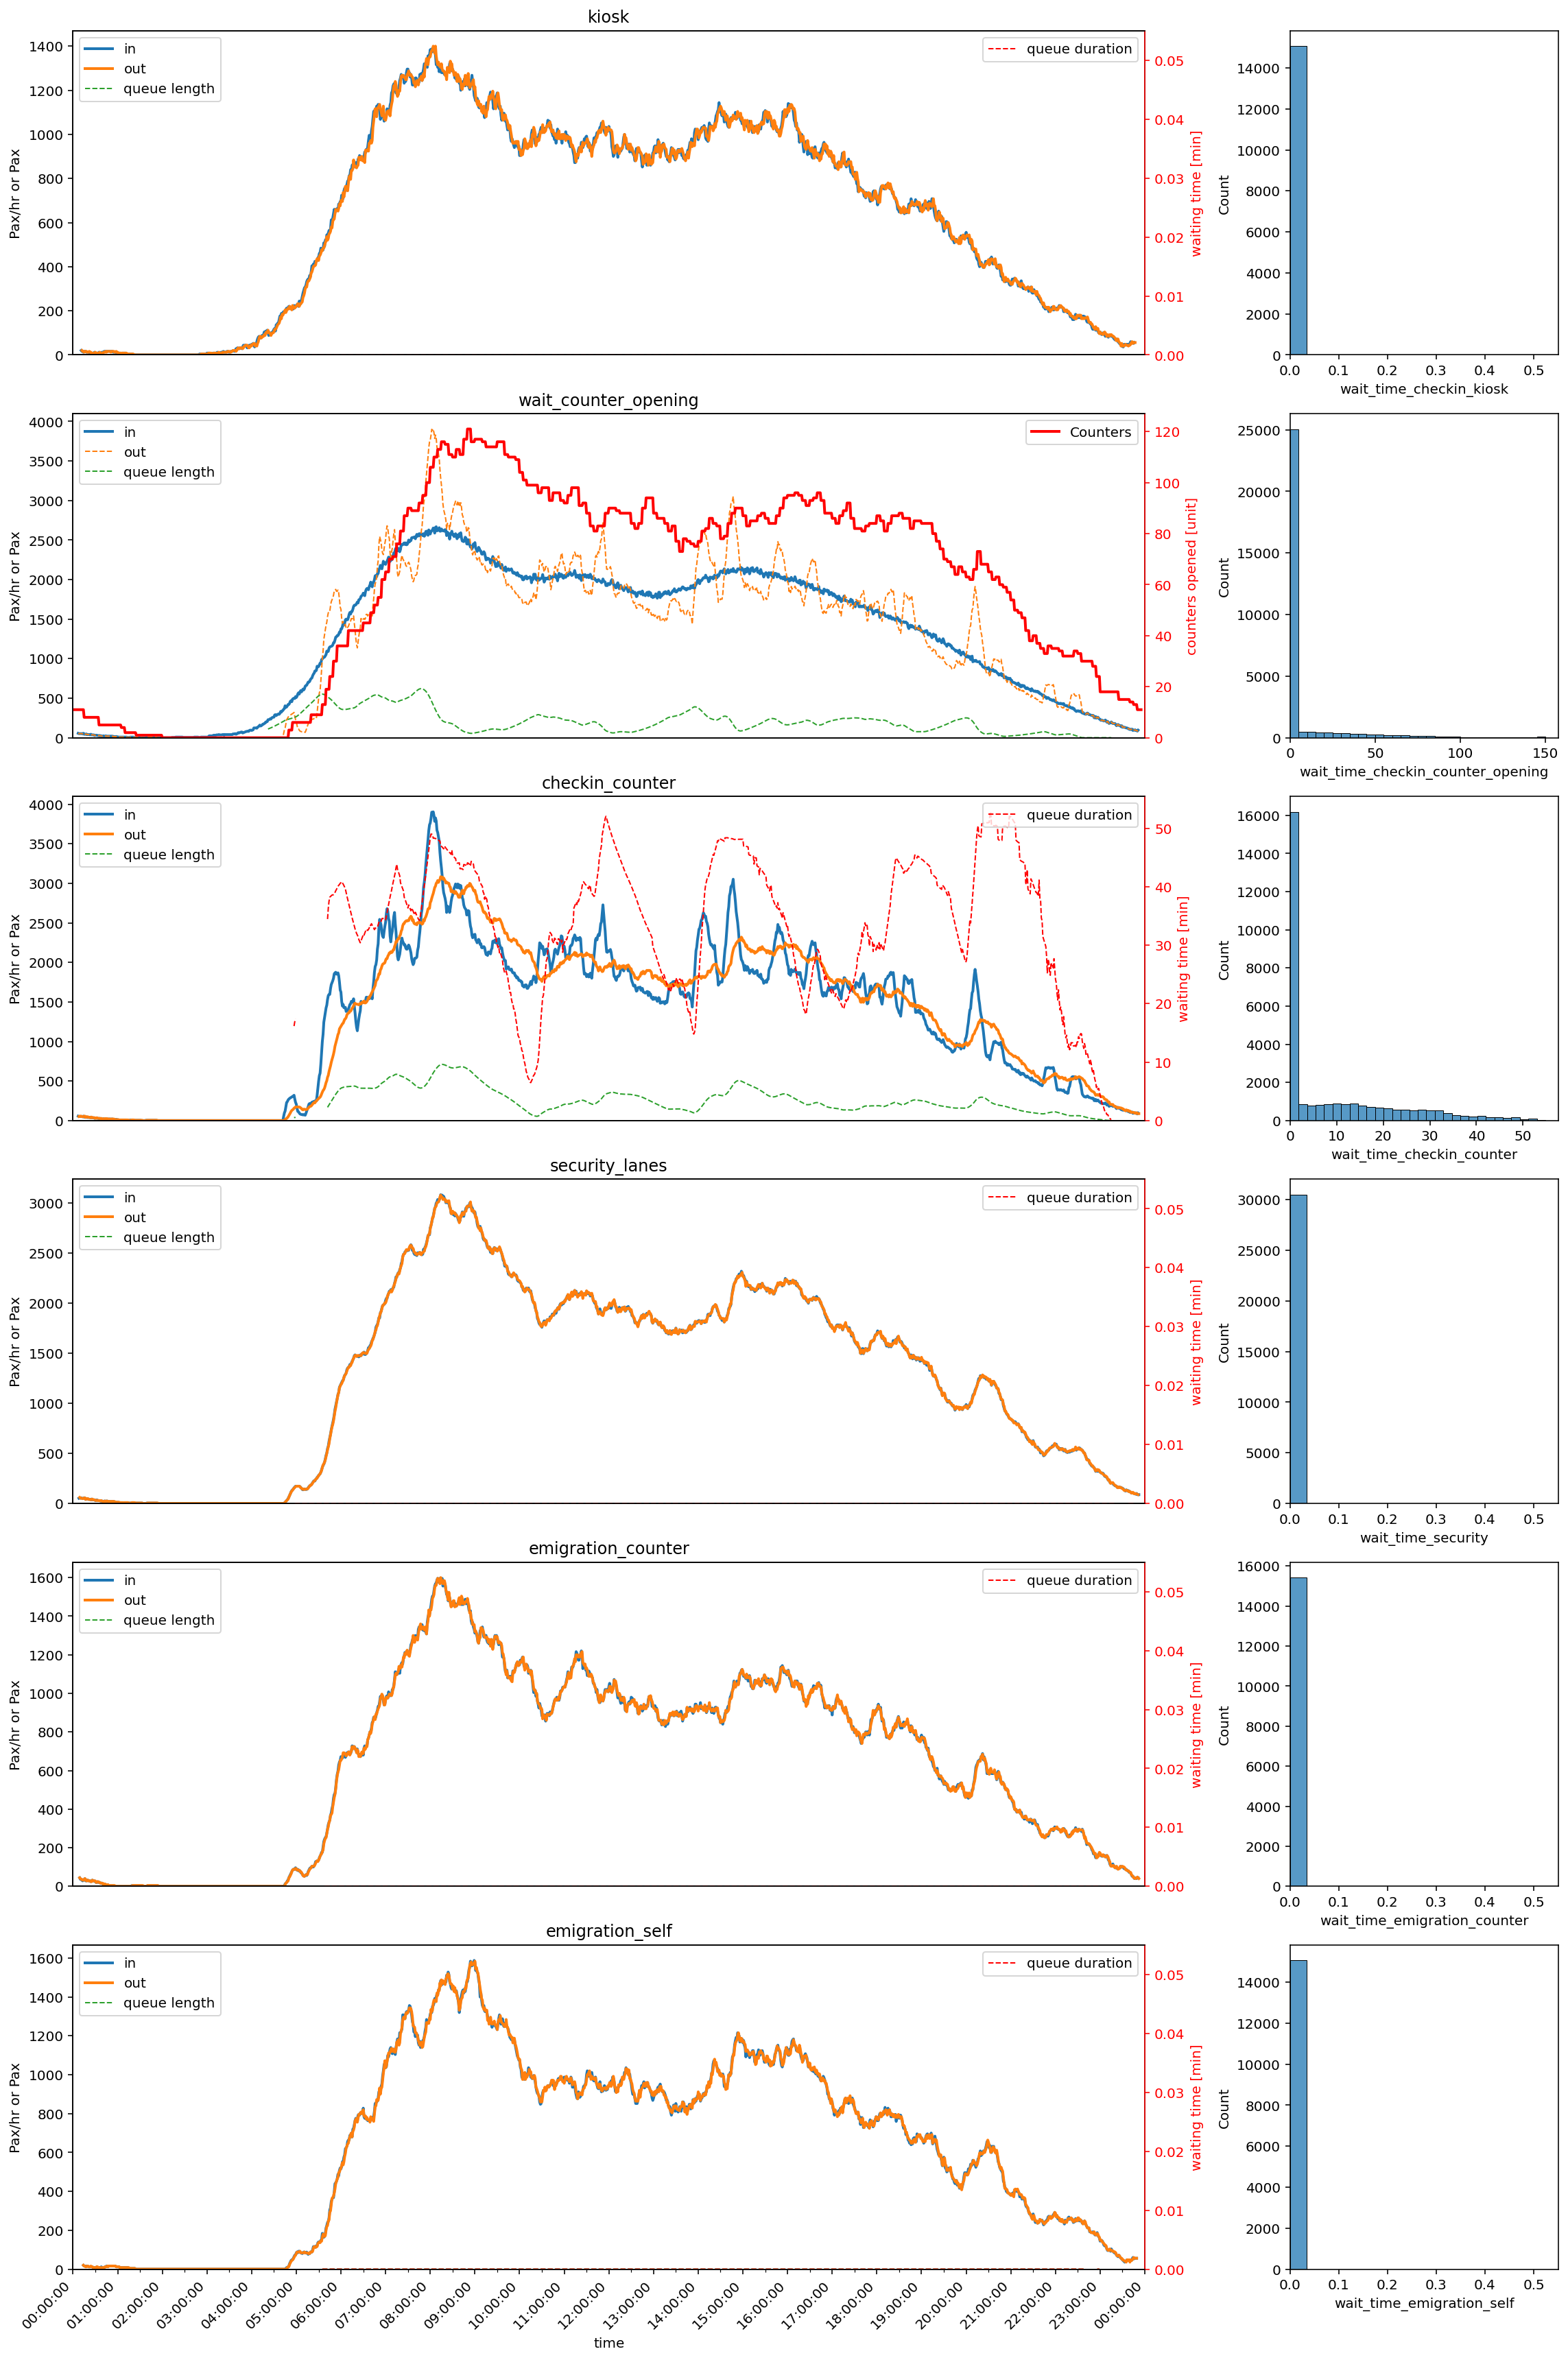

In [8]:
opening_hour = 3.5
two_step_ratio = 0.5
N_kiosk = 31

# create dct_param_opti
dct_param_opti = dct_run_param.copy()
dct_param_opti.pop("target_peak", None)

# define dct of edited check-in rule
dct_kwargs_rules = {
2.5: {
"start_time": 2.5,
"onecounter_time": 0.75,
"base_n_counter": 4,
"seats_per_add_counter": 60,
},
3: {
"start_time": 3,
"onecounter_time": 0.75,
"base_n_counter": 3,
"seats_per_add_counter": 75,
},
3.5: {
"start_time": 3.5,
"onecounter_time": 0.75,
"base_n_counter": 3,
"seats_per_add_counter": 90,
},
4: {
"start_time": 4,
"onecounter_time": 0.75,
"base_n_counter": 3,
"seats_per_add_counter": 105,
},
}

kwargs_rule = dct_kwargs_rules[opening_hour]

df_Pax, df_Counters = generate_dep_Pax_Counters(
target_peak=3580,
terminal="T1",
custom_counter_rule=True,
**kwargs_rule,
)

# as we generated base case df_Pax and df_Counters already
dct_param_opti["df_Pax"] = df_Pax
dct_param_opti["df_Counters"] = df_Counters
dct_param_opti["show_graph"] = True

dct_param_opti["modern_pax_ratio"] = (
two_step_ratio - 0.05
)  # digital pax do not change

dct_param_opti["path"] = path_dump

# run the optimized simulation once to get the waiting time, EBS and LBC numbers
(
df_result,
list_KPI_run,
dct_hist_wait_time,
dct_hist_queue_length,
) = KIX_T1_departure_sim_function(**dct_param_opti)

In [9]:
MUP_open_time=pd.Timedelta(hours=2, minutes=10)
MUP_close_time=pd.Timedelta(hours=1)

# change the times after midnight to the next day to calculate properly
end = pd.Timestamp("2020-10-13 02:00:00")
mask_late_flight = df_result["STD"] < end
df_result.loc[mask_late_flight, "STD"] += pd.Timedelta(days=1)

# mask for bags who will use EBS
# we take start security queue because some come from checkin and some from CUSBD
# we should also remove no bag pax (TBD)

mask_EBS = df_result["start_security_queue"] < df_result["STD"] - MUP_open_time
df_result.loc[mask_EBS, "EBS_in"] = df_result.loc[mask_EBS, "start_security_queue"]
df_result.loc[mask_EBS, "EBS_out"] = df_result.loc[mask_EBS, "STD"] - MUP_open_time

plt_in_EBS = (
    df_result.loc[mask_EBS, ["EBS_in", "Pax_N"]]
    .set_index("EBS_in", drop=False)["Pax_N"]
    .resample("15min")
    .agg(["sum"])
    *4
)

plt_out_EBS = (
    df_result.loc[mask_EBS, ["EBS_out", "Pax_N"]]
    .set_index("EBS_out", drop=False)["Pax_N"]
    .resample("15min")
    .agg(["sum"])
    *4
)

plt_in_EBS_cumsum = (
    df_result.loc[mask_EBS, ["EBS_in", "Pax_N"]]
    .set_index("EBS_in", drop=False)["Pax_N"]
    .resample("15min")
    .agg(["sum"])
    .cumsum()
)

plt_out_EBS_cumsum = (
    df_result.loc[mask_EBS, ["EBS_out", "Pax_N"]]
    .set_index("EBS_out", drop=False)["Pax_N"]
    .resample("15min")
    .agg(["sum"])
    .cumsum()
)

EBS_req = (plt_in_EBS_cumsum - plt_out_EBS_cumsum)

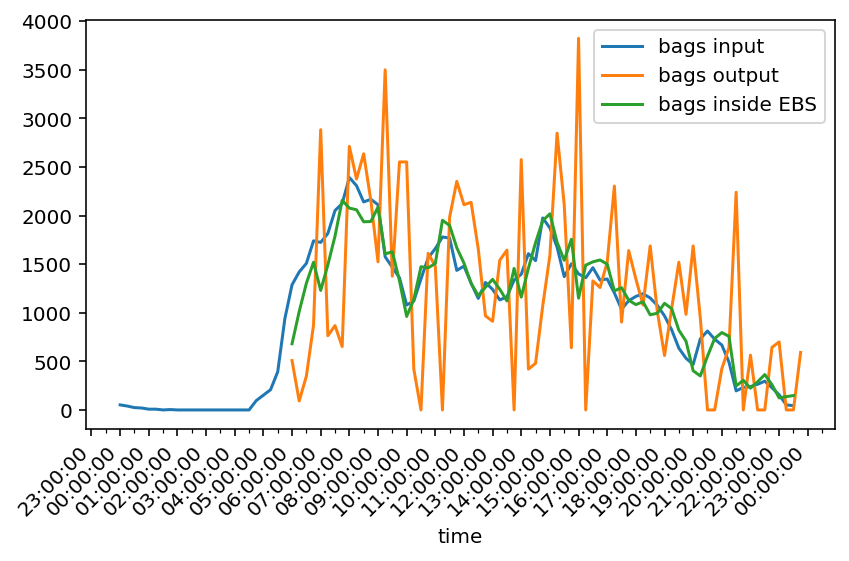

In [10]:
fig,ax = plt.subplots()
ax.plot(plt_in_EBS,label='bags input')
ax.plot(plt_out_EBS,label='bags output')
ax.plot(EBS_req,label='bags inside EBS')
ax.set_xlabel('day')
ax.set_xlabel('bags/hour')
plt.legend()

# plot param
xmin = pd.to_datetime("2020-10-13 00:00:00")
xmax = pd.to_datetime("2020-10-14 00:00:00")
plt.rcParams.update({"figure.autolayout": True})
hours = mdates.HourLocator(interval=1)
half_hours = mdates.MinuteLocator(byminute=[0, 30], interval=1)
h_fmt = mdates.DateFormatter("%H:%M:%S")

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
ax.xaxis.set_minor_locator(half_hours)

labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment="right")
ax.set(xlabel="time")


plt.show()

In [11]:
# mask for bags who will use LBC

mask_LBC = df_result["start_security_queue"] > df_result["STD"] - MUP_close_time
df_result.loc[mask_LBC, "LBC_in"] = df_result.loc[mask_LBC, "start_security_queue"]
df_result.loc[mask_LBC, "LBC_out"] = df_result.loc[mask_LBC, "STD"]

plt_in_LBC = (
    df_result.loc[mask_LBC, ["LBC_in", "Pax_N"]]
    .set_index("LBC_in", drop=False)["Pax_N"]
    .resample("15min")
    .agg(["sum"])
    .cumsum()
)

plt_out_LBC = (
    df_result.loc[mask_LBC, ["LBC_out", "Pax_N"]]
    .set_index("LBC_out", drop=False)["Pax_N"]
    .resample("15min")
    .agg(["sum"])
    .cumsum()
)

LBC_req = (plt_in_LBC - plt_out_LBC).max()

## CUSBD

Simulation running...: 100%|███████████████████████████████████████████████████████| 1440/1440 [06:26<00:00,  3.73it/s]


                                                path  \
0  C:\Users\J00638\KAP python\Airport sim\set_run...   

   Pt_checkin_1step_counter  Pt_checkin_2step_counter  N_kiosk  Pt_kiosk  \
0                  1.603333                      1.27       31       1.5   

   N_CUSBD  CUSBD_opening_duration  N_security_lanes  Pt_security_lanes  \
0       29                   210.0              22.0           0.233333   

   N_emigration_counter  ...  premium_pax_ratio  start_special_pax_ratio  \
0                  26.0  ...               0.05                     0.01   

   end_special_pax_ratio  freq  win  show_loading  show_graph  save_graph  \
0                   0.99  1min   15          True        True       False   

  save_xls  call_n_iter  
0    False         None  

[1 rows x 25 columns]


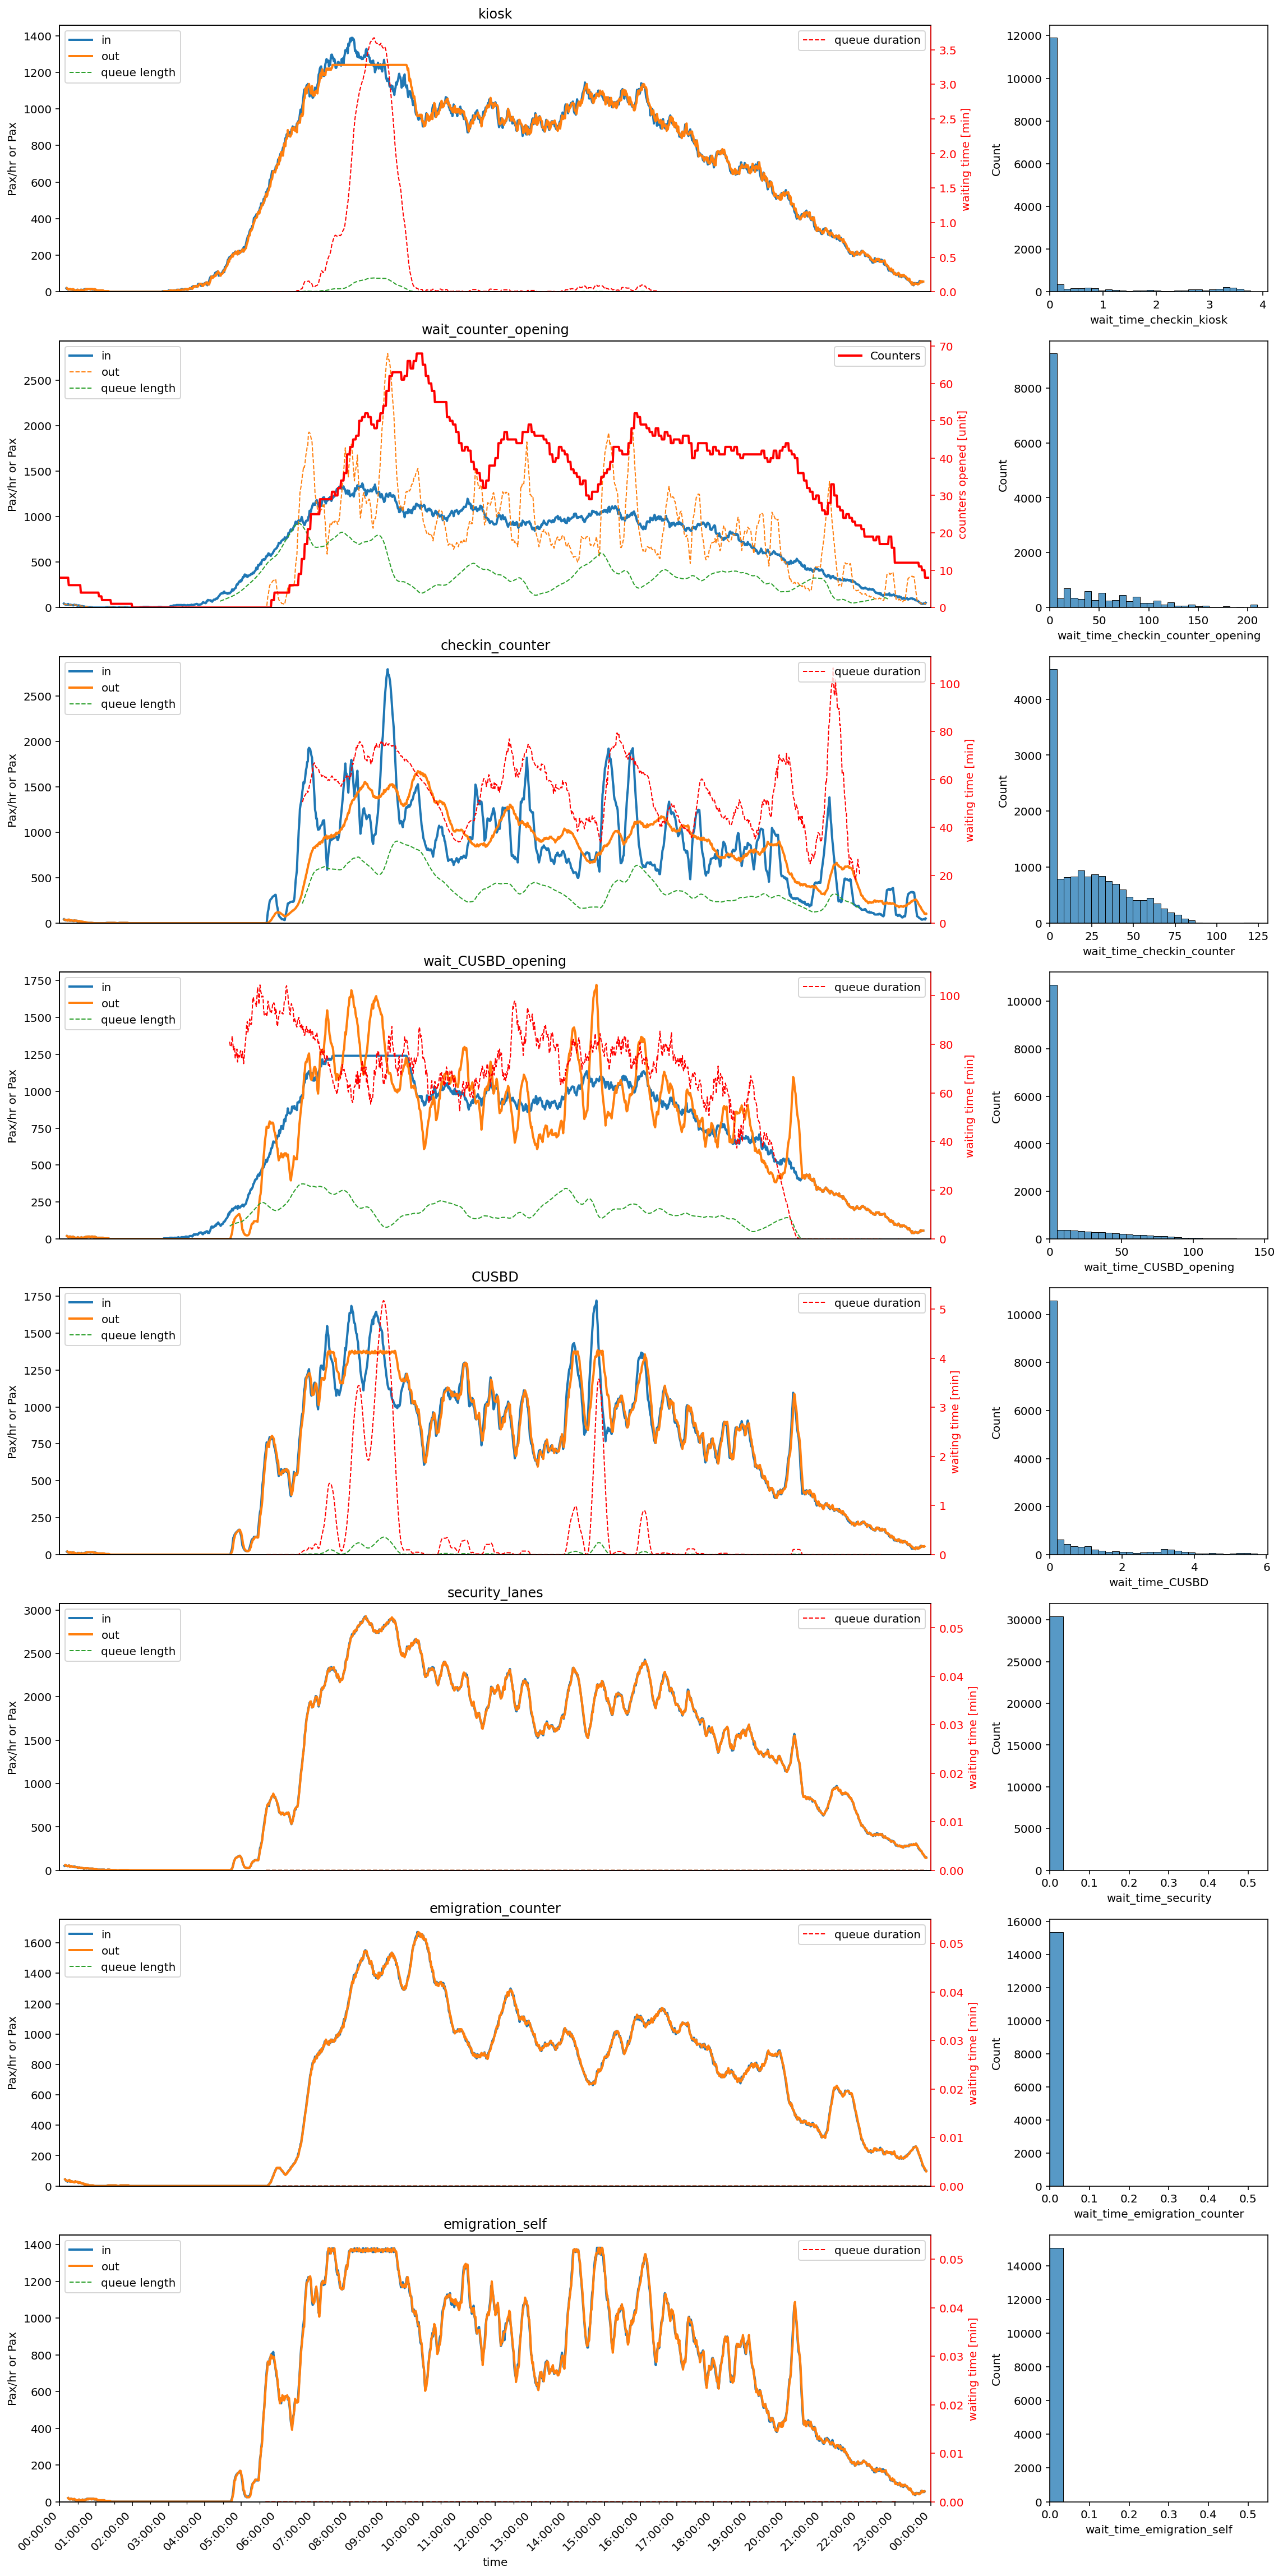

In [12]:
opening_hour = 3.5
two_step_ratio = 0.5
N_kiosk = 31
N_CUSBD = 29

dct_param_opti_CUSBD = dct_param_opti.copy()

dct_param_opti_CUSBD['show_graph'] = True
dct_param_opti_CUSBD['N_kiosk'] = N_kiosk
dct_param_opti_CUSBD['N_CUSBD'] = N_CUSBD
dct_param_opti_CUSBD["CUSBD_opening_duration"] = opening_hour * 60
dct_param_opti_CUSBD["modern_pax_ratio"] = (
two_step_ratio - 0.05
)  # digital pax do not change

# retrieve relevant kwargs_rule
kwargs_rule = {
"start_time": 2.5,
"onecounter_time": 0.75,
"base_n_counter": math.ceil(3 * (1 - two_step_ratio)),
"seats_per_add_counter": math.ceil(60 / (1 - two_step_ratio)),
}

df_Pax, df_Counters = generate_dep_Pax_Counters(
target_peak=3580,
terminal="T1",
custom_counter_rule=True,
**kwargs_rule,
)

# as we generated base case df_Pax and df_Counters already
dct_param_opti_CUSBD["df_Pax"] = df_Pax
dct_param_opti_CUSBD["df_Counters"] = df_Counters
dct_param_opti_CUSBD["path"] = path_dump

(
    df_result_CUSBD,
    list_KPI_run_CUSBD,
    dct_hist_wait_time_CUSBD,
    dct_hist_queue_length_CUSBD,
) = KIX_T1_CUSBD_departure_sim_function(**dct_param_opti_CUSBD)